<a href="https://colab.research.google.com/github/aurotripathy/RL-Experiments/blob/main/DPO_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first step is to train an SFT model, to ensure the data we train on is in-distribution for the DPO algorithm.

Then, fine-tuning a language model via DPO consists of two steps and is easier than PPO:

Data collection: Gather a preference dataset with positive and negative selected pairs of generation, given a prompt.
Optimization: Maximize the log-likelihood of the DPO loss directly.
This process is illustrated in the sketch below (from Figure 1 of the DPO paper):

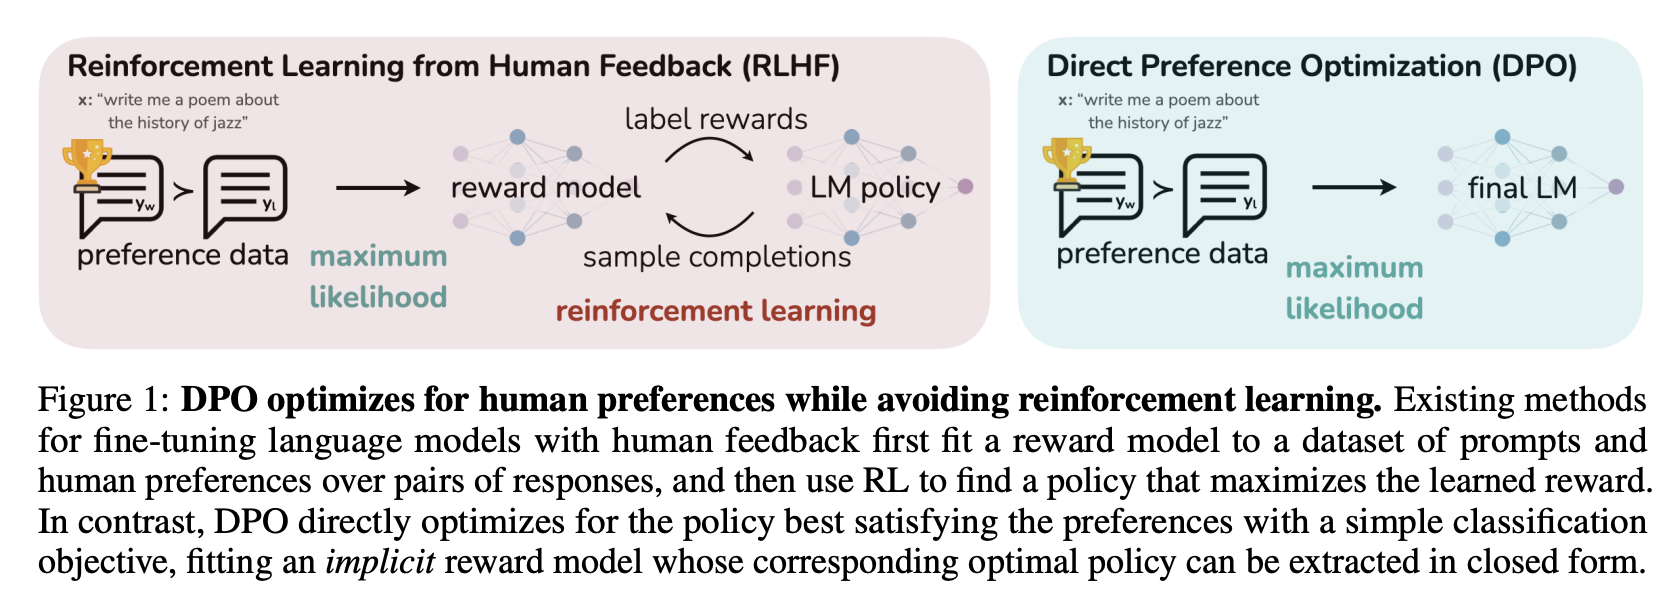

In [ ]:
%pip install transformers trl wandb

In [ ]:
# train_dpo.py
from datasets import load_dataset
from trl import DPOConfig, DPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")
train_dataset = load_dataset("trl-lib/ultrafeedback_binarized", split="train")

training_args = DPOConfig(output_dir="Qwen2-0.5B-DPO")
trainer = DPOTrainer(model=model, args=training_args, processing_class=tokenizer, train_dataset=train_dataset)
trainer.train()